# TME 5

## Degree distribution

1. A vertex's degree is the number of edges it is connected to.

2. Studying a graph's degree distribution can help understand how the graph is organized. For example, a graph with a uniform edge distribution has a degree distribution which resembles a normal curve whereas a graph which is organized as a single line only has 1-degree vertices.

3. See below

In [15]:
# Imports

import functools
from dataclasses import dataclass
from pathlib import Path
from typing import IO

import numpy as np
from matplotlib import pyplot as plt

In [16]:
# Graph class

@dataclass(frozen=True)
class Graph:
  matrix: np.ndarray

  @property
  def edge_count(self):
    return self.matrix.sum() // 2

  @property
  def vertex_count(self):
    return len(self.matrix)

  @functools.cached_property
  def degrees(self):
    return self.matrix.sum(axis=0)

  @classmethod
  def parse(cls, file: IO[str], /):
    edges = set[tuple[int, int]]()
    vertex_names = list[str]()
    vertex_count = 0

    def get_vertex(name: str):
      if name in vertex_names:
        return vertex_names.index(name)

      vertex = len(vertex_names)
      vertex_names.append(name)
      return vertex

    for raw_line in file.readlines():
      line = raw_line.strip()

      if line:
        a, b = [get_vertex(x) for x in line.split(',')]
        edges.add((a, b))
        vertex_count = max(vertex_count, a + 1, b + 1)

    matrix = np.zeros((vertex_count, vertex_count), dtype=bool)

    for a, b in edges:
      matrix[a, b] = True
      matrix[b, a] = True

    # print(*[f'{n}={vertex_names.index(n)}' for n in ['A', 'B', 'C', 'D', 'E']])

    return Graph(matrix), vertex_names

In [17]:
# Load graphs

with Path('reseau1.txt').open() as file:
  graph1, _ = Graph.parse(file)

with Path('reseau2.txt').open() as file:
  graph2, _ = Graph.parse(file)

with Path('reseau3.txt').open() as file:
  graph3, graph3_names = Graph.parse(file)

/var/folders/cx/nqf16kln5bjd2n8jnp2yb00m0000gn/T/ipykernel_46160/2488816219.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


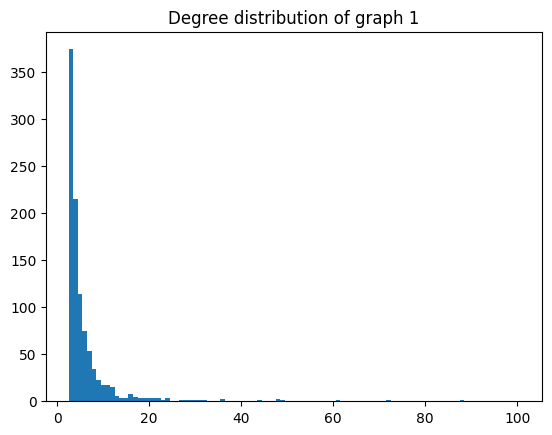

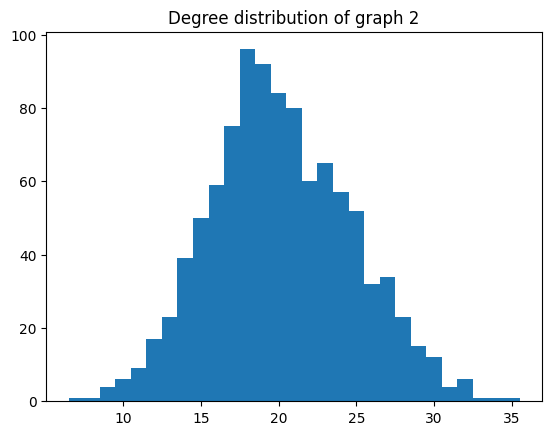

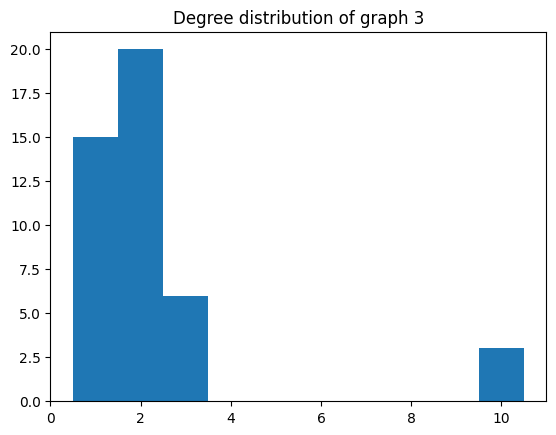

In [39]:
# Plot the degree distribution of each graph

for index, graph in enumerate([graph1, graph2, graph3]):
  fig, ax = plt.subplots()

  ax.hist(graph.degrees, bins=(np.arange(graph.degrees.min(), graph.degrees.max() + 1) - 0.5))
  ax.set_title(f'Degree distribution of graph {index + 1}')

  fig.show()

4. A scale-free network is a graph with a degree distribution that follows a power law. Graph 1 has a distribution that resembles a power law so it is likely scale free. Graph 2 has a distribution that resembles a normal curve so it is likely random. Graph 3 is too small to be characterized.


## Clustering coefficient


In [19]:
def clustering_coefficients(graph: Graph):
  triange_double_count = graph.degrees * (graph.degrees - 1)

  return np.divide(
    (graph.matrix & graph.matrix[:, :, None] & graph.matrix[:, None, :]).sum(axis=(0, 1)),
    triange_double_count,
    out=np.zeros(graph.vertex_count),
    where=(triange_double_count > 0)
  )


In [25]:
ccs = [clustering_coefficients(graph) for graph in [graph1, graph2, graph3]]

graph3_main_names = ['A', 'B', 'C', 'D', 'E']
graph3_main_vertices = [graph3_names.index(name) for name in ['A', 'B', 'C', 'D', 'E']]

for name, cc in zip(graph3_main_names, ccs[2][graph3_main_vertices]):
  print(f'cc({name}) = {cc}')

cc(A) = 0.0
cc(B) = 0.07272727272727272
cc(C) = 0.044444444444444446
cc(D) = 0.3333333333333333
cc(E) = 0.13333333333333333


In [27]:
for index, cc in enumerate(ccs):
  print(f'Average clustering coefficient in graph {index + 1}: {cc.mean()}')

Average clustering coefficient in graph 1: 0.027004490481315823
Average clustering coefficient in graph 2: 0.02035174679994944
Average clustering coefficient in graph 3: 0.4574186307519641


1. See above
2. Graph 2 has a much higher average clustering coefficient, therefore there is a much higher local interconnectivity in that graph.


## Betweenness centrality

1. TODO
2. See below

In [40]:
# Seidel's algorithm aka APD

def apd(input_a: np.ndarray, /):
  n = len(input_a)

  mask = ~np.eye(n, dtype=bool)
  stack = [input_a]

  while (a := stack[-1]).sum() < n ** 2 - n:
    stack.append((a | (a @ a)) & mask)

  t = stack[-1]

  for a in stack[-2::-1]:
    x = t @ a.astype(int)
    degrees = a.sum(axis=0)
    t = 2 * t - (x < t * degrees)

  return t


def betweenness_centralities(graph: Graph):
  int_dtype = np.uint16

  n = graph.vertex_count
  distances = apd(graph.matrix)

  shortest_path_counts = np.zeros((n, n), dtype=int_dtype)
  shortest_path_incl = np.zeros((n, n, n), dtype=int_dtype)

  for target_node in list(range(n)):
    current_path_count = np.zeros(n, dtype=int_dtype)
    current_path_count[target_node] = 1

    path_count = np.zeros(n, dtype=int_dtype)
    path_count[target_node] = 1

    distances_through_target_node = distances[target_node, :] + distances[target_node, :, None]
    is_node_on_path = (distances_through_target_node == distances)

    while current_path_count.any():
      current_path_count = (current_path_count @ graph.matrix) * (path_count < 1)
      path_count += current_path_count

    path_count[target_node] = 0
    shortest_path_incl[target_node, :, :] = (path_count[:, None] @ path_count[None, :]) * is_node_on_path

  shortest_path_counts = shortest_path_incl.sum(axis=0, dtype=int_dtype) // np.maximum(distances - 1, 1) + graph.matrix

  return (shortest_path_incl / np.maximum(shortest_path_counts, 1)).sum(axis=(1, 2))

In [35]:
# This takes 2 Go of RAM and about 10 seconds to run
betweenness_centralities(graph1)

array([1.38735151e+05, 5.13691078e+04, 1.18568075e+05, 1.70618590e+05,
       6.84766826e+04, 5.17205517e+02, 5.50881781e+04, 3.11276592e+04,
       7.00439348e+03, 1.64934944e+03, 1.26219229e+04, 7.36184209e+03,
       5.10389656e+03, 8.51388070e+03, 1.25570646e+02, 1.81616871e+04,
       8.44893077e+03, 1.60613319e+04, 1.51339078e+03, 7.40953945e+03,
       2.66428165e+04, 2.03500348e+04, 1.34803945e+02, 2.21921021e+02,
       1.24844633e+04, 5.12431739e+02, 5.13791993e+03, 4.70747904e+03,
       4.39710325e+02, 1.64772738e+03, 3.62632370e+03, 1.55983068e+04,
       1.02548455e+04, 6.78126074e+02, 6.12263682e+03, 6.04794822e+02,
       2.83425452e+03, 3.59155784e+03, 4.45223202e+02, 3.85317416e+02,
       1.87873023e+03, 7.36885274e+02, 4.68387987e+02, 1.32166535e+03,
       8.38580414e+03, 5.66647384e+03, 4.29587704e+03, 2.49279328e+02,
       1.12217845e+03, 5.98113605e+02, 6.42965189e+03, 8.75547413e+02,
       4.38132561e+02, 2.76200675e+03, 5.56756650e+03, 1.85960386e+03,
      

In [36]:
# Same here
betweenness_centralities(graph2)

array([2358.86032174,  888.59157524, 1900.16287019, 2771.03603011,
       1937.02096451, 2141.53105651, 2211.45629935, 3275.57804569,
       1877.31056642, 1205.76188528,  316.51305089, 1233.81090412,
       4886.44881998,  746.21954658, 2230.15191427,  909.41654695,
       2458.91973123, 1509.44483302, 2036.2964782 , 2235.44952991,
       1566.45890671,  613.10604413, 2140.19150677, 2793.47176968,
        591.9974128 , 1135.75033459, 1440.69397873, 1001.10328817,
       1649.73462586, 2998.74232366, 1080.32562812, 1307.86965759,
       1936.06163744, 1653.63550673, 1979.54437054, 1901.79085893,
       2734.63420366, 1335.36597338, 2003.33337474, 2071.21645854,
       1755.14149735, 1542.10495585, 1486.16430378, 3962.17496294,
       1340.16842814, 2250.32966183,  986.5512786 , 1467.13757965,
        552.1260263 , 1357.79456604,  898.59595441, 2507.03568098,
       2447.7886991 , 2313.56024968, 1171.19998932,  943.38006764,
       1350.78462135, 1588.6686523 , 1175.86893291, 2586.30175

In [33]:
bcs = betweenness_centralities(graph3)

for name, bc in zip(graph3_main_names, bcs[graph3_main_vertices]):
  print(f'bc({name}) = {bc}')

bc(A) = 702.0
bc(B) = 1222.0
bc(C) = 1244.0
bc(D) = 768.0
bc(E) = 686.0
